# ALEX17 Diurnal Cycles Benchmark: A Large Domain In Complex Terrain
## Introduction
This is the model evaluation notebook of the ALEX17 benchmark. A guide for participants can be found [here](https://thewindvaneblog.com/alex17-diurnal-cycles-benchmark-a-large-domain-in-complex-terrain-b5029e94485).

## Load libraries

In [42]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from lib.alex17_functions import *  
from lib.nc_read_functions import *  
from IPython.display import Markdown, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Participants

In [8]:
# Read file with simulation descriptions
sims = pd.read_csv('./outputs/alex17_sims.csv')
n_sim = len(sims)

## Input Data
### Elevation Map and Instrument Layout

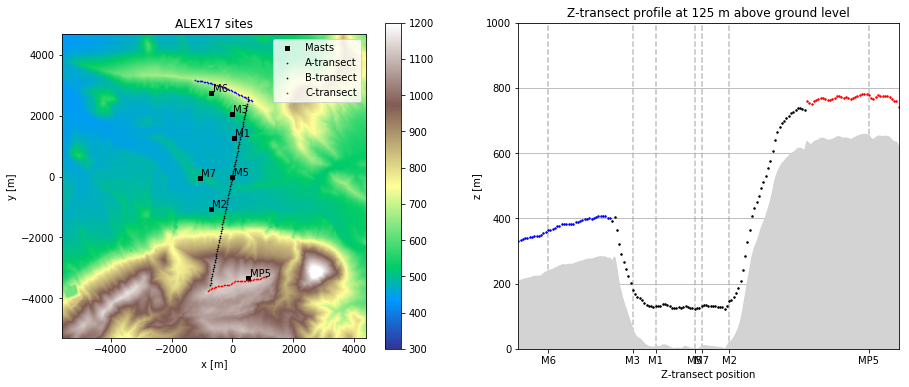

In [4]:
# Site
siteID = 'alex17'

# Evaluation period
datefrom = datetime.datetime(2018,9,30,0,0,0)    
dateto = datetime.datetime(2018,10,4,0,0,0)  

# Mast positions
masts = pd.read_csv('./inputs/masts.csv') # read {x,y,z} coordinates of target masts
masts = masts.drop(masts[masts['Name']=='WLS70'].index)
         
# Z-transect
Ztransect = pd.read_csv('./inputs/Ztransect.csv') # read {x,y,x} coordinates of Z-transect 
A_ind = Ztransect['Name'].str.contains('A') # Tajonar ridge scan
B_ind = Ztransect['Name'].str.contains('B') # Elortz valley scan
C_ind = Ztransect['Name'].str.contains('C') # Alaiz ridge scan

# Topography
topo = rio.open('./inputs/DTM_Alaiz_2m.tif') # read nc file in UTM coordinates
box = [612000 , 622000, 4726000, 4736000]    # evaluation area

# Change to local coordinate system
ref = 'M5' # reference site to define origin of coordinate system
ref = masts[masts['Name'] == ref][['easting[m]','northing[m]','elevation[m]']].values[0].tolist()
masts['x'] = masts['easting[m]'] - ref[0]
masts['y'] = masts['northing[m]'] - ref[1]
masts['z'] = masts['elevation[m]'] - ref[2]
Ztransect['x'] = Ztransect['easting[m]'] - ref[0]
Ztransect['y'] = Ztransect['northing[m]'] - ref[1]
Ztransect['z'] = Ztransect['elevation[m]'] - ref[2]
box_xy = [612000 - ref[0], 622000- ref[0], 4726000 - ref[1], 4736000 - ref[1]]    # evaluation area

# Plot elevation map and validation sites
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
basemap = basemap_plot(topo, masts, Ztransect, ref, ax1, coord = 'xy')
ax1.set_xlim(box_xy[0:2])
ax1.set_ylim(box_xy[2:4])
Zprofile = Ztransect_plot(masts, Ztransect, ax2)

### Mesoscale Input Data
Mesoscale simulations have been produced adopting most of the WRF settings that were used in the production run of the New European Wind Atlas (NEWA). Three one-way nested domains of 27, 9 and 3 km resolution are configured centred at the wind farm centroid. The vertical grid has 61 terrain-following (sigma) levels, with 10 levels covering the first 200 meters, more specifically at: 6, 22, 40, 56, 73, 90, 113, 140, 179 and 205 meters. High resolution topography (SRTM 90m) and updated land use categories (Corine Land Cover 2018), together with the Noah land-surface model are used to define the boundary conditions at the surface. The physical parameterizations are: Mellor–Yamada–Nakanishi Niino 2.5-level planetary boundary-layer scheme (MYNN), WRF Single-Moment 5-class microphysics scheme, the Rapid Radiative Transfer Model for GCMs shortwave and longwave radiation schemes and the Kain-Fritsch cumulus scheme in the outermost domains 1 and 2. The simulation is driven by input data from ERA-5 in blocks of 5 days with additional spin-up time of 24 hours.   

From the 3-km domain we extract output data that will be used as reference in validation plots. This constitute the baseline simulation (*alex17_00a*) that we try to improve with microscale modeling. 

In [5]:
# Load WRFref output data
masts_sim = [read_sim('./outputs/alex17_00a_masts.nc')] # mast profiles

Ztransect_sim = [read_sim('./outputs/alex17_00a_Ztransect.nc')] # Z_transect

box_sim = [read_sim('./outputs/alex17_00a_box.nc')] # horizontal planes 


## Validation Data
Three sets of measurements will be used for validation of the submitted results. The meteorological mast measurements are available for the modelers to check and calibrate their results, whereas the lidar measurements will be used for validation after submission (blind test). 
1. Vertical profiles at *mast* positions.
2. Wind vector at 125m a.g.l. along the *Z-transect*.
3. Vertical RHI plane across the valley along the *B* segment of the *Z-transect*. The Plane connects WS3 [617846.796; 4732496.246] km and WS5 [617305.590; 4729848.751] km.

In [6]:
# Mast data
masts_obs = read_obs('./observations/masts_obs.nc') # mast profiles

# Z-Transect data
#f_Ztransect = './observations/alex17_Ztransect.nc'



## Simulation Data
We load the simulations defined in *sims* table. Three sets of output data are collected from each simulation: 

1. *simID_masts.nc*: Vertical profiles extending 1km from the surface at the met mast locations (*inputs/masts.csv* coordinates);
2. *simID_Ztransect.nc*: Vertical planes along the Z-transect extending 1 km in the vertical (*inputs/Ztransect.csv* coordinates);
3. *simID_box.nc*: Horizontal planes at 125 m and 40 m a.g.l., with horizontal resolution of 100 m, within the “box” [612–622; 4726–4736] km.

Output data is provided based on 10-min averages.

In [9]:
for i_sim in range(1,n_sim): # i_sim = 0 was already loaded
    masts_sim.append(read_sim('./outputs/'+ sims["ID"][i_sim] +'_masts.nc')) # masts
    Ztransect_sim.append(read_sim('./outputs/'+ sims["ID"][i_sim] +'_Ztransect.nc'))  # Z-transect planes
    box_sim.append(read_sim('./outputs/'+ sims["ID"][i_sim] +'_box.nc')) # horizontal planes


## Compute Quantities of Interest and Metrics

In [10]:
# wind shear 
alpha = np.log(masts_obs.wind_speed.sel(height = 80)/masts_obs.wind_speed.sel(height = 40))/np.log(80./40.)
masts_obs =  masts_obs.assign(wind_shear = alpha)
for i_sim in range(0,n_sim):
    alpha = np.log(masts_sim[i_sim].wind_speed.interp(height= 80)/masts_sim[i_sim].wind_speed.interp(height= 40))/np.log(80./40.)
    masts_sim[i_sim] = masts_sim[i_sim].assign(wind_shear = alpha)

## Results

In [13]:
len(masts_sim)

2

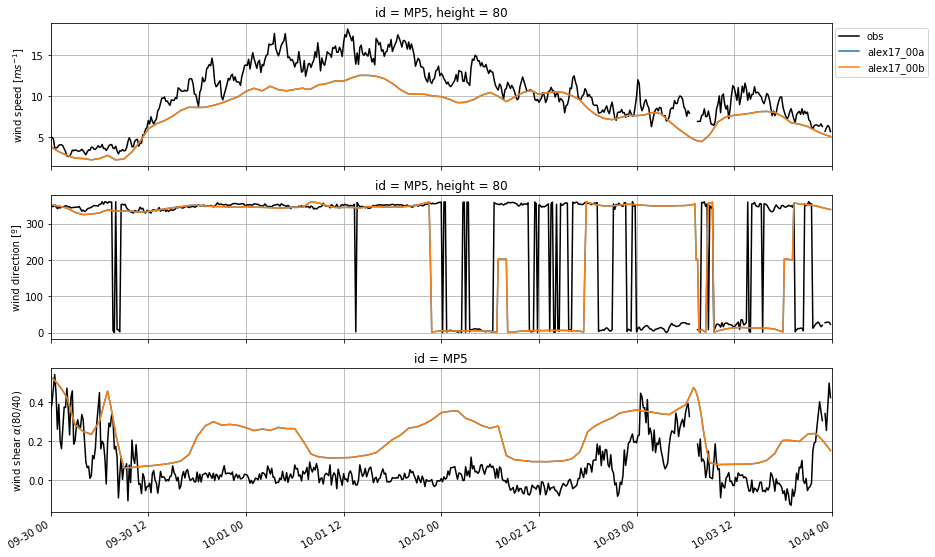

In [15]:
# Plot time-series 
mast = 'MP5'
h = 80

ax = mast_sims_vs_obs_timeseries_plot(mast, h, masts_obs, masts_sim, sims, datefrom, dateto)

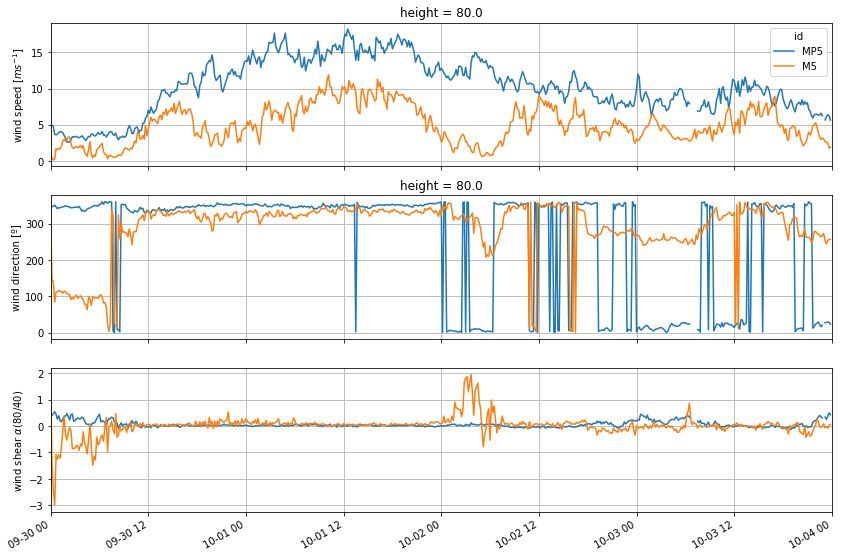

In [17]:
# MP5 vs M5
h = 80
mast = ['MP5','M5']

ax = compare_masts_timeseries_plot(mast, h, masts_obs, datefrom, dateto)

In [39]:

masts_obs.coords['id'].values.tolist()


['MP5', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7']

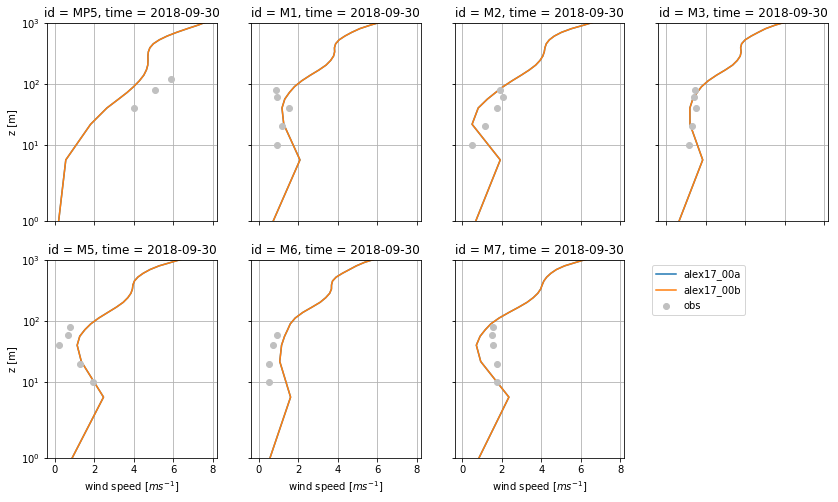

In [41]:
# Vertical profiles
t = datefrom

ax = masts_sims_vs_obs_profiles_plot(t, masts_obs, masts_sim, sims, datefrom, dateto)

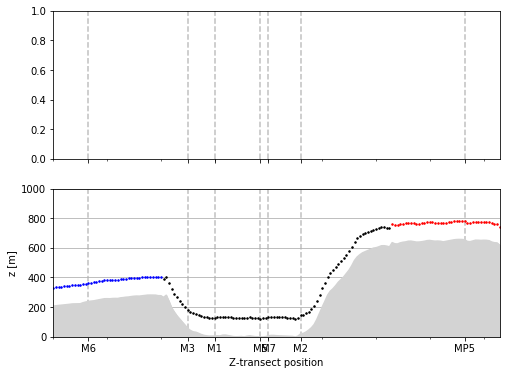

In [44]:
# Plot Z-transect
h = 125.

#ax = Ztransect_sims_vs_obs_plot(t, Ztransect_obs, Ztransect_sim, masts, Ztransect)
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (8,6), sharex = True)
Zprofile = Ztransect_plot(masts, Ztransect, ax2)
ax2.set_title('')
#for i_sim in range (0,n_sim):
    #Ztransect_sim[i_sim].wind_speed.sel(height = h).plot(x = 'id', label = sims['ID'][i_sim], ax = ax1)
#ax1.legend(bbox_to_anchor=(1, 1))
masts_inZ = [] # index of Z_transect position nearest to each mast
for i, row in masts.iterrows():
    d = np.sqrt((Ztransect['x'] - masts['x'][i])**2 + (Ztransect['y'] - masts['y'][i])**2)
    masts_inZ.append(d[d == d.min()].index[0])
for x in masts_inZ:
    ax1.axvline(x, color = 'silver', linestyle = '--', zorder = 0)


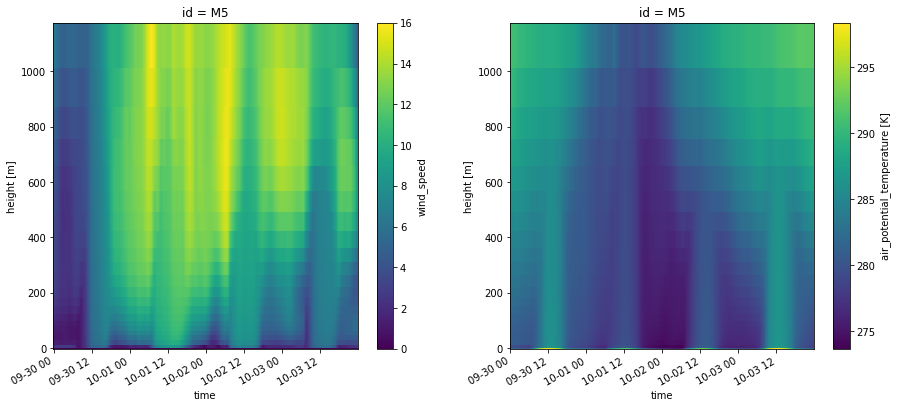

In [110]:
# tz contour plot
i_sim = 0
mast = 'M5'
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
ax1 = masts_sim[i_sim].wind_speed.sel(id = mast).plot(ax = ax1)
ax2 = masts_sim[i_sim].air_potential_temperature.sel(id = mast).plot(ax = ax2);

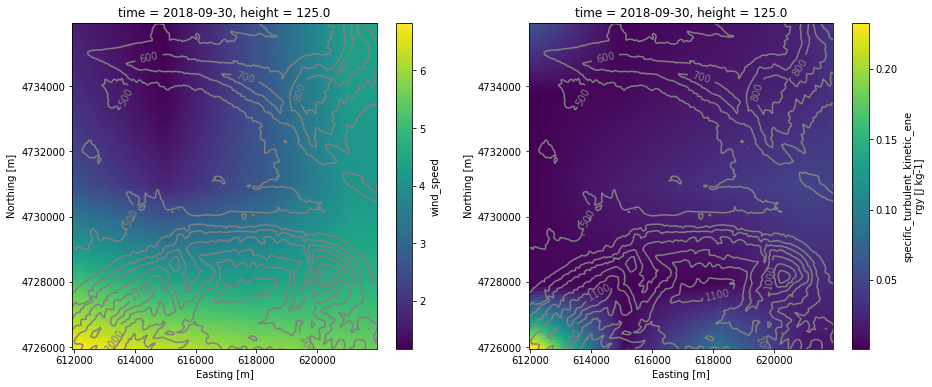

In [109]:
# xy contour plots
i_sim = 0
h = 125.
t = datefrom

S = box_sim[i_sim].wind_speed.sel(time = t, height = h)
TKE = box_sim[i_sim].specific_turbulent_kinetic_energy.sel(time = t, height = h)

oview = topo.overviews(1)[2] # choose overview (0 is largest, -1 is the smallest)
basemap = topo.read(1, out_shape=(1, int(topo.height // oview), int(topo.width // oview)))
basemap = np.ma.masked_where(basemap == 0 , basemap, copy=True) 
basemap = np.flipud(basemap)
res = (max_E-min_E)*oview/topo.width
min_E, max_E = topo.bounds.left, topo.bounds.right
min_N, max_N = topo.bounds.bottom, topo.bounds.top
X, Y = np.meshgrid(np.arange(min_E + res/2, max_E - res/2, res), np.arange(min_N + res/2, max_N - res/2, res))

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
h_box = S.plot(x = 'easting', y = 'northing', ax = ax1)
ctopo = ax1.contour(X,Y,basemap, colors = 'grey', levels = list(range(0, 3000, 100)))
ax1.clabel(ctopo, inline=1, fontsize=10, fmt = '%i')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]') 

h_box = TKE.plot(x = 'easting', y = 'northing', ax = ax2)
ctopo = ax2.contour(X,Y,basemap, colors = 'grey', levels = list(range(0, 3000, 100)))
ax2.clabel(ctopo, inline=1, fontsize=10, fmt = '%i')
ax2.set_xlabel('Easting [m]')
ax2.set_ylabel('Northing [m]'); 